In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import tensorflow as tf
import numpy as np
from malaya_speech.train.model import fastspeech, fastvc
from math import ceil
import malaya_speech
import matplotlib.pyplot as plt






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





In [3]:
from glob import glob

In [4]:
speaker_model = malaya_speech.speaker_vector.deep_model('vggvox-v2')

In [5]:
path = 'fastvc-32-checkpoint'
ckpt_path = tf.train.latest_checkpoint(path)
ckpt_path

'fastvc-32-checkpoint/model.ckpt-300000'

In [6]:
mel = tf.placeholder(tf.float32, (None, None, 80), name = 'mel')
ori_vector = tf.placeholder(tf.float32, (None, 512), name = 'ori_vector')
target_vector = tf.placeholder(tf.float32, (None, 512), name = 'target_vector')
mel_lengths = tf.placeholder(tf.int32, (None), name = 'mel_lengths')

In [7]:
dim_neck = 32
config = malaya_speech.config.fastspeech_config
config['encoder_hidden_size'] = 512 + 80
config['decoder_hidden_size'] = 512 + dim_neck
config['hidden_dropout_prob'] = 0.0
config['attention_probs_dropout_prob'] = 0.0
config = fastspeech.Config(vocab_size = 1, **config)
model = fastvc.model.Model(dim_neck, config)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
encoder_outputs, mel_before, mel_after, codes = model(mel, ori_vector, target_vector, 
                                                      mel_lengths, training = True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
mel_before = tf.identity(mel_before, name = 'mel_before')
mel_after = tf.identity(mel_before, name = 'mel_after')

In [10]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

/home/husein/.local/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [11]:
var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
saver = tf.train.Saver(var_list = var_list)
saver.restore(sess, ckpt_path)

INFO:tensorflow:Restoring parameters from fastvc-32-checkpoint/model.ckpt-300000


In [12]:
saver = tf.train.Saver()
saver.save(sess, 'fastvc-32-output/model.ckpt')

'fastvc-32-output/model.ckpt'

In [24]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or 'mel' in n.name
        or '_vector' in n.name
        or 'logits' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
        and 'IsVariableInitialized' not in n.name
        and 'IsInitialized' not in n.name
    ]
)
strings.split(',')

['import/logits',
 'mel',
 'ori_vector',
 'target_vector',
 'mel_lengths',
 'fastvc/mel_before/kernel/Initializer/random_uniform/shape',
 'fastvc/mel_before/kernel/Initializer/random_uniform/min',
 'fastvc/mel_before/kernel/Initializer/random_uniform/max',
 'fastvc/mel_before/kernel/Initializer/random_uniform/RandomUniform',
 'fastvc/mel_before/kernel/Initializer/random_uniform/sub',
 'fastvc/mel_before/kernel/Initializer/random_uniform/mul',
 'fastvc/mel_before/kernel/Initializer/random_uniform',
 'fastvc/mel_before/kernel',
 'fastvc/mel_before/bias/Initializer/zeros',
 'fastvc/mel_before/bias',
 'fastvc/mel_before/Tensordot/axes',
 'fastvc/mel_before/Tensordot/free',
 'fastvc/mel_before/Tensordot/Shape',
 'fastvc/mel_before/Tensordot/Const',
 'fastvc/mel_before/Tensordot/Prod',
 'fastvc/mel_before/Tensordot/Const_1',
 'fastvc/mel_before/Tensordot/Prod_1',
 'fastvc/mel_before/Tensordot/concat/axis',
 'fastvc/mel_before/Tensordot/concat',
 'fastvc/mel_before/Tensordot/stack',
 'fastvc/

In [25]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [26]:
freeze_graph('fastvc-32-output', strings)

INFO:tensorflow:Restoring parameters from fastvc-32-output/model.ckpt
INFO:tensorflow:Froze 132 variables.
INFO:tensorflow:Converted 132 variables to const ops.
3313 ops in the final graph.


In [27]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
                
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
        
    return graph

In [28]:
g = load_graph('fastvc-32-output/frozen_model.pb')

In [29]:
from tensorflow.tools.graph_transforms import TransformGraph
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-1024, fallback_max=1024)',
             'strip_unused_nodes',
             'sort_by_execution_order']

In [30]:
pb = 'fastvc-32-output/frozen_model.pb'
input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           ['mel', 'ori_vector', 'target_vector', 'mel_lengths'],
                                           ['mel_before', 'mel_after'], transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.


In [33]:
import IPython.display as ipd

In [34]:
import librosa

config = {'sampling_rate': 22050,
 'fft_size': 1024,
 'hop_size': 256,
 'win_length': None,
 'window': 'hann',
 'num_mels': 80,
 'fmin': 80,
 'fmax': 7600,
 'global_gain_scale': 1.0,
 'trim_silence': True,
 'trim_threshold_in_db': 20,
 'trim_frame_size': 2048,
 'trim_hop_size': 512}

mel_stats = np.load('universal-stats/stats.npy')

def get_mel(file):
    if isinstance(file, str):
        audio, _ = malaya_speech.load(file, sr = config['sampling_rate'])
    else:
        audio = file
    D = librosa.stft(
        audio,
        n_fft=config['fft_size'],
        hop_length=config['hop_size'],
        win_length=config['win_length'],
        window=config['window'],
        pad_mode='reflect',
    )
    S, _ = librosa.magphase(D) 
    fmin = 0 if config["fmin"] is None else config["fmin"]
    fmax = sampling_rate // 2 if config["fmax"] is None else config["fmax"]
    mel_basis = librosa.filters.mel(
        sr=config['sampling_rate'],
        n_fft=config["fft_size"],
        n_mels=config["num_mels"],
        fmin=fmin,
        fmax=fmax,
    )
    mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
    audio = np.pad(audio, (0, config["fft_size"]), mode="edge")
    audio = audio[: len(mel) * config['hop_size']]
    mel = (mel - mel_stats[0]) / mel_stats[1]
    return audio, mel

In [35]:
from glob import glob

haqkiem = glob('/home/husein/speech-bahasa/haqkiem/*.wav')
turki = glob('/home/husein/youtube/malay2/turki/*/*.wav')
dari_pasentran = glob('/home/husein/youtube/malay/dari-pasentran-ke-istana/*/*.wav')
salina = glob('/home/husein/youtube/malay2/salina/*/*.wav')

In [37]:
index = 4
audio_haqkiem, mel_haqkiem = get_mel(haqkiem[index])
ipd.Audio(audio_haqkiem, rate = 22050)

In [ ]:
audio_haqkiem, mel_haqkiem = get_mel('test-2.wav')
ipd.Audio(audio_haqkiem, rate = 22050)

In [39]:
audio_salina, mel_salina = get_mel(salina[index])
ipd.Audio(audio_salina, rate = 22050)

In [ ]:
enhancer = malaya_speech.speech_enhancement.deep_enhance(model = 'unet-enhance-24')

In [ ]:
y, sr = malaya_speech.load('mas-aisyah.wav', sr = 22050)
logits = enhancer.predict(y)
audio_salina, mel_salina = get_mel(logits)

In [ ]:
vctk = glob('vtck/**/*.flac', recursive = True)
len(vctk)

In [ ]:
from collections import defaultdict
import random

vctk_speakers = defaultdict(list)
for f in vctk:
    s = f.split('/')[-1].split('_')[0]
    vctk_speakers[s].append(f)
    
speakers = []
    
for s in vctk_speakers.keys():
    speakers.extend(random.sample(vctk_speakers[s], min(400, len(vctk_speakers[s]))))
    
len(speakers)

In [ ]:
vctk_speakers.keys()

In [ ]:
a = random.choice(vctk_speakers['p300'])
ipd.Audio(a)

In [ ]:
audio_salina, mel_salina = get_mel(random.choice(vctk_speakers['p360']))

In [ ]:
# audio_salina, mel_salina = get_mel('wadi-annuar.wav')

In [40]:
v_left = speaker_model([audio_haqkiem])[0] * 30 - 3.5
v_right = speaker_model([audio_salina])[0] * 30 - 3.5

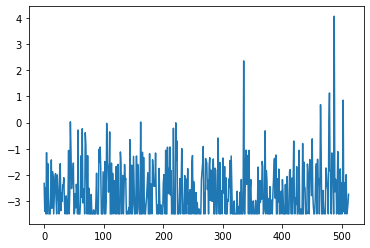

In [41]:
plt.plot(v_left)

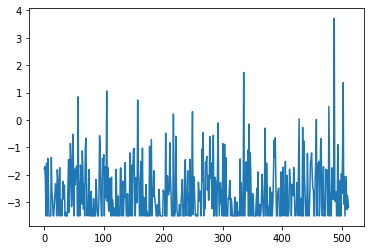

In [42]:
plt.plot(v_right)

In [43]:
r = sess.run([mel_before, mel_after], feed_dict = {mel: [mel_haqkiem], 
                                                   ori_vector: [v_left],
                                              target_vector: [v_right],
                                                  mel_lengths: [len(mel_haqkiem)]})

In [44]:
b = r[0][0]
a = r[1][0]
r[0].shape, np.abs(b - mel_haqkiem).mean(), np.abs(a - mel_haqkiem).mean()

((1, 709, 80), 0.26449764, 0.26449764)

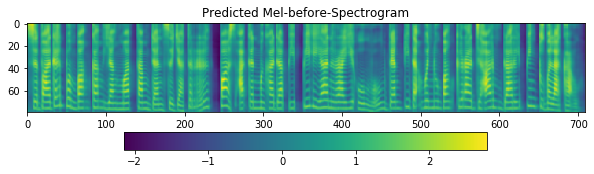

In [45]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(b), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

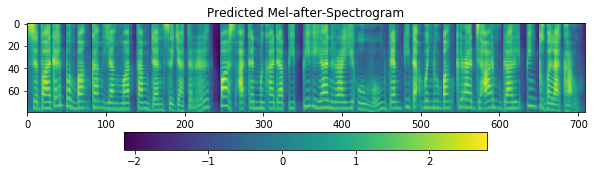

In [46]:
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(311)
ax1.set_title('Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(a), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

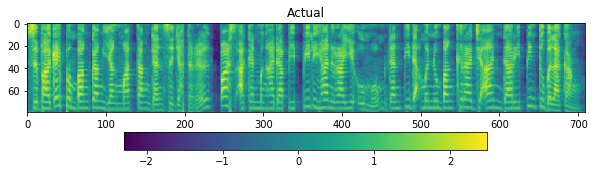

In [47]:
mel_outputs_ = mel_haqkiem
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('Actual')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [48]:
# import pickle

# with open('a.pkl', 'wb') as fopen:
#     pickle.dump([b, a, mel_haqkiem, mel_salina], fopen)

In [49]:
saver = tf.train.Saver()
saver.save(sess, 'fastvc-32-output/model.ckpt')

'fastvc-32-output/model.ckpt'